# Project 2: Reinforcement Learning agent to play Snake

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from numpy.random import randint

class SnakeGame:
    " Implements the snake game core"

    def __init__(self, width, height, food_amount=1,
                 border = 0, grass_growth = 0,
                 max_grass = 0):
        "Initialize board"
        self.width = width
        self.height = height
        self.board = np.zeros( (height,width,3),dtype = np.float32)
        self.food_amount = food_amount
        self.border = border
        self.grass_growth = grass_growth
        self.grass = np.zeros( (height,width) ) + max_grass
        self.max_grass = max_grass
        self.reset()

    def create_apples(self):
        "create a new apple away from the snake"
        while len(self.apples)<self.food_amount:
            apple = ( randint(0,self.height-1), randint(0,self.width-1) )
            while apple in self.snake:
                apple = ( randint(0,self.height-1), randint(0,self.width-1) )
            self.apples.append(apple)

    def create_snake(self):
        "create a snake, size 3, at random position and orientation"
        x = randint( 5, self.width-5 )   # not t0o close to border
        y = randint( 5, self.height-5 )
        self.direction = randint(0,4)
        self.snake = []
        for i in range(5):
            if self.direction == 0:
                y = y+1
            elif self.direction==1:
                x = x-1
            elif self.direction==2:
                y = y-1
            elif self.direction==3:
                x = x+1
            self.snake.append( (y,x) )

    def grow_snake(self, d):
        "add one position to snake head (0=up, 1=right, 2=down, 3=left)"
        y,x = self.snake[0]
        if d == 0:
            y = y-1
        elif d == 1:
            x = x+1
        elif d == 2:
            y = y+1
        else:
            x = x-1
        self.snake.insert(0,(y,x))

    def check_collisions(self):
        "check if game is over by colliding with edge or itself"
        # just need to check snake's head
        x,y = self.snake[0]
        if (x == -1 or x == self.height
            or y == -1 or y == self.width
            or (x,y) in self.snake[1:]):
            self.done = True

    def step(self, action):
        """
        move snake/game one step
        action can be -1 (turn left), 0 (continue), 1 (turn rignt)
        """
        direction = int(action)
        assert -1<=direction<=1
        self.direction+=direction
        if self.direction<0:
            self.direction = 3
        elif self.direction>3:
            self.direction = 0
        self.grow_snake(self.direction)  # two steps: grow+remove last
        if self.snake[0] in self.apples:
            self.apples.remove(self.snake[0])
            reward = 1
            self.create_apples()     # new apple
        else:
            self.snake.pop()
            self.check_collisions()
            if self.done:
                reward = -1
            else:
                reward = 0
        if reward>=0:
            x,y = self.snake[0]
            reward += self.grass[x,y]
            self.grass[x,y] = 0
            self.score+=reward
            self.grass += self.grass_growth
            self.grass[self.grass>self.max_grass] = self.max_grass

        return self.board_state(),reward,self.done, {'score':self.score}

    def get_state(self):
        "easily get current state (score, apple, snake head and tail)"
        score = self.score
        apple = self.apples
        head = self.snake[0]
        tail = self.snake[1:]
        return score,apple,head,tail,self.direction

    def print_state(self):
        "print the current board state"
        for i in range(self.height):
            line='.'*self.width
            for x,y in self.apples:
                if y==i:
                    line = line[:x]+'A'+line[x+1:]
            for s in self.snake:
                x,y=s
                if y==i:
                    line = line[:x]+'X'+line[x+1:]
            print(line)

    def test_step(self, direction):
        "to test: move the snake and print the game state"
        self.step(direction)
        self.print_state()
        if self.done:
            print("Game over! Score=",self.score)

    def reset(self):
        "reset state"
        self.score = 0
        self.done = False
        self.create_snake()
        self.apples = []
        self.create_apples()
        self.grass[:,:] =  self.max_grass

        return self.board_state(),0,self.done, {'score':self.score}

    def board_state(self, mode='human', close=False):
        "Render the environment"
        self.board[:,:,:] = 0
        if self.max_grass>0:
            self.board[:,:,1] = self.grass/self.max_grass * 0.3
        if not self.done:
            x,y = self.snake[0]
            self.board[x,y,:] = 1
        for x,y in self.snake[1:]:
            self.board[x,y,0] = 1
        for x,y in self.apples:
            self.board[x,y,1] = 1
        if self.border == 0:
            return self.board
        else:
            h,w,_ = self.board.shape
            board = np.full((h+self.border*2,w+self.border*2,3),0.5,np.float32)
            board[self.border:-self.border,self.border:-self.border] = self.board
            return board

#just run this if this file is the main
if __name__ == '__main__':
    game = SnakeGame(20,20)
    game.print_state()




............X.......
........A...X.......
............X.......
............X.......
............X.......
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................


## 3. Exploration Strategies

In [ ]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Select the corresponding device
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [ ]:
# Define the hyperparameters
N_ACTIONS       = 3        # A = [left,forward,right] = [-1,0,1]
BOARD_SIZE      = 30       # Grid without boarder
BORDER          = 1        # Size of the boarder for each extremity
IN_CHANNELS     = 1        # Number of channels of the image (here we used rgb images but we actually use a grayscale version)
EPS_START       = 1.0      # Initial value of epsilon for the epsilon-greedy strategy
EPS_END         = 0.05     # Final value of epsiolon
EPS_DECAY       = 5000    # controls the rate of exponential decay of epsilon, higher means a slower decay
GAMMA           = 0.99     # Discount factor
LR              = 1e-4     # Learning rate
MAX_EPISODES = 10000        # Maximum number of episodes (doesn't include the episodes using heuristic)
PRETRAIN_EPISODES   = 100   # Maximum number of episodes using the heuristic function
MAX_STEPS       = 500     # Maximum number of steps within an episode
BATCH_SIZE = 64            # Number of transitions used for each training
BUFFER_CAPACITIES = [64,10000]    # Array of differents values for the buffer capacity

assert PRETRAIN_EPISODES <= MAX_EPISODES, "You can't have more pretrain episodes than the total number of episodes"
assert BATCH_SIZE <= min(BUFFER_CAPACITIES), "The maximum capacity of each buffer must be above the size of the batch"


In [ ]:
def preprocess(board):
    """
    Preprocess the board given by the function board_state(). It is a numpy array of shape (height,width,3).
    Therefore we want to transform this numpy image into a pytorch tensor of format [1,1,32,32] (1 batch, 1 channel,h,w)
    input: a frame corresponding to the current state of the game gird
    output: the preprocessed frame
    """
    gray = 0.2989 * board[:, :, 0] + 0.5870 * board[:, :, 1] + 0.1140 * board[:, :, 2]
    tensor = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)
    return tensor.to(torch.float32).to(device)

In [ ]:
# Here we use a CNN model that will take as an input a preprocessed frame of the grid of the game
# And will provide as an output the Q-values for each possible actions
# Reminder: Conv2D(in_channels,out_channels,kernel_size,stride)
#
class DQN(nn.Module):
    def __init__(self, input_channels=IN_CHANNELS, num_actions=N_ACTIONS):
        super(DQN,self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.conv3 = nn.Conv2d(32, 32, 2, 1)
        self.fc1   = nn.Linear(800, 512)
        self.fc2   = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x is still a 4D tensor at that point, therefore we need to flatten it before fc1
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

policy_net = DQN()
policy_net = policy_net.to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [ ]:
# Define the batch
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
def Q_learning_loss(policy_net, batch):
    """
    Loss function that computes the difference between the predicted Q-values and the target Q-values.
    Input: policy_net: model taking the images of the grid and computing the action to take
            batch: transion with the state, next_state, action and reward
    Output: Return the loss in a format of a scalar
    """
    # Q(s,a)
    q_pred = policy_net(batch.state).gather(1, batch.action)

    with torch.no_grad():
        # max of a' on Q(s',a')
        q_next = policy_net(batch.next_state).max(1, keepdim=True).values
        # r + GAMME * maxS(s',a')
        q_target = batch.reward + GAMMA * q_next

    mse = nn.MSELoss()
    # (r + GAMME * maxS(s',a') - Q(s,a))²
    return mse(q_target,q_pred)


In [ ]:
LEFT = -1
STRAIGHT = 0
RIGHT = 1
DIRS = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}

def heuristic(state, height, width):
    """
    Heuristic based on the Manhattan distance. It will compute which direction to take in order to
    reduce the Manhattan distance and to avoid collisions with the border or itself
    Input: state: tuple containing the position of the head of the snake, the position of the apple,
    the direction of the snake and the postion of its tail
    Input: height: value of the height of the grid of the game
    Input: width: value of the width of the grid of the game
    Output: The action that the snake should take (i.e the direction to go to)
    """
    h_row,h_col = state[2] # Position of the head
    a_row,a_col = state[1][0] # Position of the first apple
    dx,dy = a_col-h_col, a_row-h_row
    current_dir = state[4]
    tail_set = set(state[3]) # Position of each block of the snape except the head

    # Directions: north=0, est=1, south=2, west=3   (The schema is to help visualize the directions)
    #      0 y-
    #       |
    # 3 x- --- x+ 1
    #       |
    #      2 y+

    if abs(dx) > abs(dy):
        # Case: the biggest distance is horizontal and the snake is on the left of the apple
        if dx > 0:
            target_dir = 1

        # Case: the biggest distance is horizontal and the snake is on the right of the apple
        else:
            target_dir = 3
    else:
        # Case: the biggest distance is vertical and the snake is above the apple
        if dy > 0:
            target_dir = 2
        # Case: the biggest distance is vertical and the snake is below the apple
        else:
            target_dir = 0

    best_action = STRAIGHT
    best_dist = height*width # Initialize with a higher value than anything possible so that the first safe action is better
    safe_actions = []

    # Compute for every possible actions the new position of the head of the snake
    for action in (LEFT,STRAIGHT,RIGHT):
        direction = (current_dir + action) % 4
        mov_row, mov_col = DIRS[direction]
        new_h_row, new_h_col =  h_row + mov_row, h_col + mov_col

        if 0 <= new_h_row <= height and 0 <= new_h_col <= width: # Verify it doesn't collide with the border
            if not (new_h_row, new_h_col) in tail_set: # Verify it doesn't collide with its tail
                safe_actions.append(action)
                dist = abs(new_h_col - a_col) + abs(new_h_row - a_row)
                if dist < best_dist:
                    best_dist = dist
                    best_action = action

    return best_action

### 3.1 Implementing Epsilon-Greedy

In [15]:
"""### 3.1 Implementing Epsilon-Greedy"""

scores = []
losses = []
apples = []
eps_history = []
steps_done = 0

env = SnakeGame(BOARD_SIZE, BOARD_SIZE, border=BORDER)

for ep in range(1, MAX_EPISODES + 1):

    board, _, done, info = env.reset()
    state_img = preprocess(board)
    ep_ret = 0
    apples_ep = 0

    for t in range(MAX_STEPS):
        game_state = env.get_state()
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)

        # Select the heuristic if we are in training mode
        if ep < PRETRAIN_EPISODES:
            action = heuristic(game_state, BOARD_SIZE+2*BORDER, BOARD_SIZE+2*BORDER)
            next_board, reward, done, info = env.step(action)
        # Else select the action based on the epsilon-greedy algorithm
        else:
            eps_history.append(eps)
            q_values = policy_net(state_img)
            if torch.rand(1).item() < eps:
                action_idx = torch.randint(0, N_ACTIONS, (1,), device=device)
            else:
                action_idx = torch.argmax(q_values, dim=1)
            # Go from [0,1,2] to [-1,0,1]
            action = int(action_idx.item()) - 1
            next_board, reward, done, info = env.step(action)

        if reward > 0:
            apples_ep += 1

        next_state_img = preprocess(next_board)

        action_idx = torch.tensor([[action + 1]], device=device)
        batch = Transition(state_img,
                        action_idx,
                        next_state_img,
                        torch.tensor([[reward]], dtype=torch.float32, device=device),
                        torch.tensor([[float(done)]], dtype=torch.float32, device=device))

        loss = Q_learning_loss(policy_net, batch)
        optimizer.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
        optimizer.step()
        losses.append(loss.item())

        state_img = next_state_img

        # if not done:
        #     reward += 0.1
        ep_ret += reward
        steps_done += 1
        # Finish the episode if the snake died
        if done:
            break

    scores.append(ep_ret)
    apples.append(apples_ep)

    if ep % 100 == 0:
        avg_score = sum(scores[-100:]) / 100
        avg_loss  = sum(losses[-100*min(MAX_STEPS,100):]) / (100*min(MAX_STEPS,100))
        print(f"Episode: {ep}. Average score: {avg_score}. Loss: {avg_loss}. Epsilon: {eps}")



KeyboardInterrupt: 

### 3.2 Implementing Boltzmann Exploration

[Boltzmann] Episode  100 | Avg Score (last 100): 23.320 | T (last step): 10.0000
[Boltzmann] Episode  200 | Avg Score (last 100): 23.950 | T (last step): 10.0000
[Boltzmann] Episode  300 | Avg Score (last 100): 24.470 | T (last step): 10.0000
[Boltzmann] Episode  400 | Avg Score (last 100): 23.190 | T (last step): 10.0000
[Boltzmann] Episode  500 | Avg Score (last 100): 23.780 | T (last step): 10.0000
[Boltzmann] Episode  600 | Avg Score (last 100): -0.980 | T (last step): 8.4264


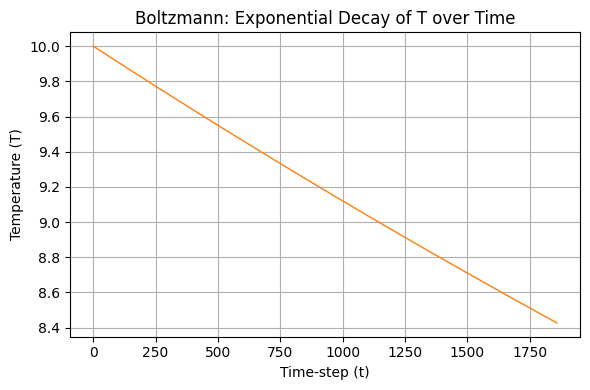

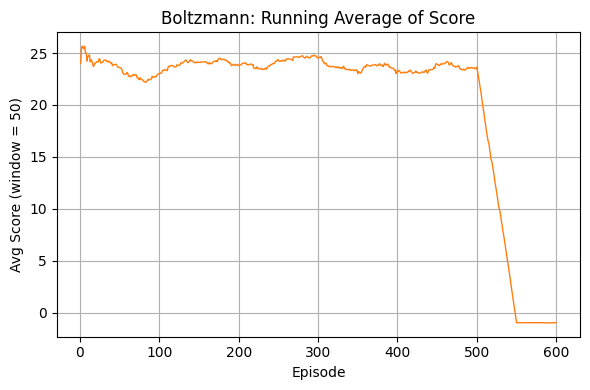

In [ ]:
# (Re)Initialize a fresh DQN & optimizer for Boltzmann
policy_net_b     = DQN().to(device)
optimizer_b      = optim.AdamW(policy_net_b.parameters(), lr=LR, amsgrad=True)
policy_net_b.train()

# Boltzmann hyperparameters (slower decay)
T_START       = 10.0     # hold a larger temperature initially
T_END         = 0.1      # final low temperature
T_DECAY_STEPS = 50000    # decay temperature over 50k steps

scores_boltz      = []
losses_boltz      = []
apples_boltz      = []
temp_history      = []
steps_done_boltz  = 0
action_hist_boltz = []

for ep in range(1, MAX_EPISODES + 1):
    board, _, done, _ = env.reset()
    state_img = preprocess(board).to(device)
    ep_ret    = 0
    apples_ep = 0

    # Record initial T (optional)
    frac_T = min(steps_done_boltz / T_DECAY_STEPS, 1.0)
    T      = T_START * ((T_END / T_START) ** frac_T)

    for t in range(MAX_STEPS):
        # ─── Fix #1: grab the current state before calling heuristic ───
        game_state = env.get_state()

        # Pretraining: use the heuristic for the first PRETRAIN_EPISODES
        if ep <= PRETRAIN_EPISODES:
            action = heuristic(
                game_state,
                BOARD_SIZE + 2*BORDER,
                BOARD_SIZE + 2*BORDER
            )
            next_board, reward, done, info = env.step(action)

        else:
            # Compute & record decayed temperature T
            frac_T = min(steps_done_boltz / T_DECAY_STEPS, 1.0)
            T      = T_START * ((T_END / T_START) ** frac_T)
            temp_history.append(T)

            # Forward pass (no grad) to get Q‐values [3]
            with torch.no_grad():
                q_vals = policy_net_b(state_img).squeeze(0)

            # Softmax over Q‐values (stability trick)
            max_q  = q_vals.max()
            exp_q  = torch.exp((q_vals - max_q) / T)
            probs  = exp_q / exp_q.sum()

            # Sample an action index {0,1,2} with P ∝ exp((Q(s,a)-maxQ)/T)
            action_idx = torch.multinomial(probs, 1)  # shape [1]
            action     = int(action_idx.item()) - 1   # map → {-1,0,+1}

            next_board, reward, done, _ = env.step(action)
            steps_done_boltz += 1
            action_hist_boltz.append(action_idx.item())

        # Count apples eaten
        if reward > 0:
            apples_ep += 1

        next_state_img = preprocess(next_board).to(device)

        # Build transition for TD‐loss
        action_idx_t = torch.tensor([[action + 1]], device=device)   # {0,1,2}
        reward_t     = torch.tensor([[reward]], dtype=torch.float32, device=device)
        done_t       = torch.tensor([[float(done)]], dtype=torch.float32, device=device)

        batch = Transition(
            state_img,
            action_idx_t,
            next_state_img,
            reward_t,
            done_t
        )

        # TD‐loss and gradient step
        loss_b = Q_learning_loss(policy_net_b, batch)
        optimizer_b.zero_grad()
        loss_b.backward()
        nn.utils.clip_grad_norm_(policy_net_b.parameters(), 1.0)
        optimizer_b.step()
        losses_boltz.append(loss_b.item())

        state_img = next_state_img
        ep_ret   += reward

        if done:
            break

    # End of Boltzmann episode
    scores_boltz.append(ep_ret)
    apples_boltz.append(apples_ep)

    if ep % 100 == 0:
        recent_avg = sum(scores_boltz[-100:]) / 100
        print(
            f"[Boltzmann] Episode {ep:4d} | "
            f"Avg Score (last 100): {recent_avg:.3f} | "
            f"T (last step): {T:.4f}"
        )

# ───────────────────────────────
# Plot Temperature Decay
# ───────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(temp_history, linewidth=1, color="tab:orange")
plt.xlabel("Time‐step (t)")
plt.ylabel("Temperature (T)")
plt.title("Boltzmann: Exponential Decay of T over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────────────────────────
# Plot Running Average of Boltzmann Scores
# ───────────────────────────────
window = 50
running_avg_b = []
for i in range(len(scores_boltz)):
    if i < window:
        running_avg_b.append(sum(scores_boltz[: i+1]) / (i+1))
    else:
        running_avg_b.append(sum(scores_boltz[i-window+1 : i+1]) / window)

# Plot only up to however many episodes you actually ran
num_eps_b = len(running_avg_b)
plt.figure(figsize=(6,4))
plt.plot(
    range(1, num_eps_b+1),
    running_avg_b,
    color="tab:orange",
    linewidth=1
)
plt.xlabel("Episode")
plt.ylabel(f"Avg Score (window = {window})")
plt.title("Boltzmann: Running Average of Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.3 Comparative Analysis

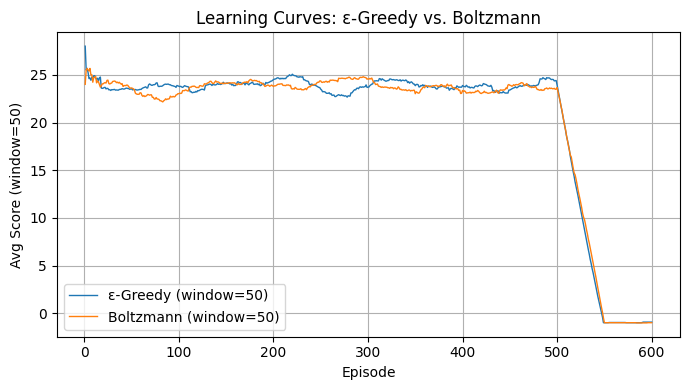

Final 200-episode avg (ε-Greedy):   11.355
Final 200-episode avg (Boltzmann):   11.400


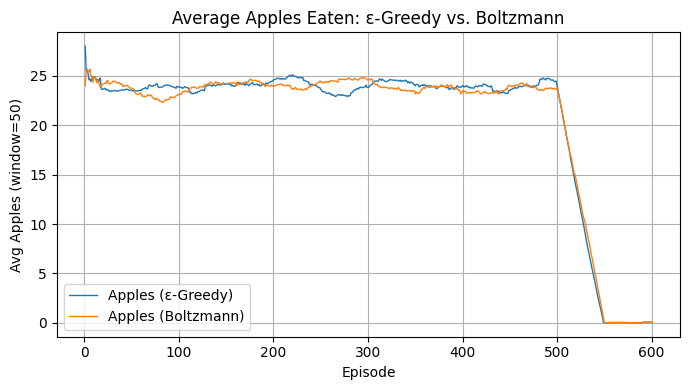

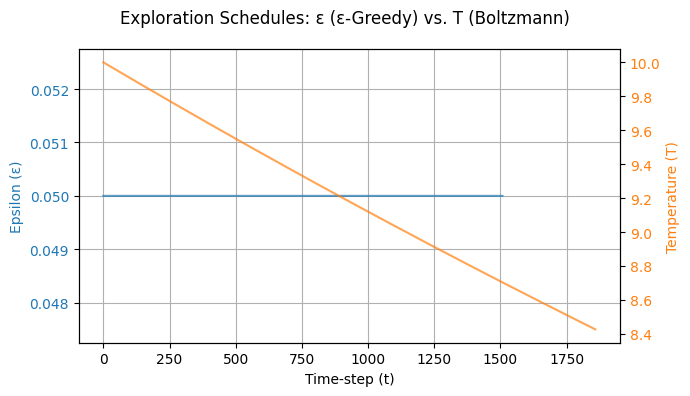

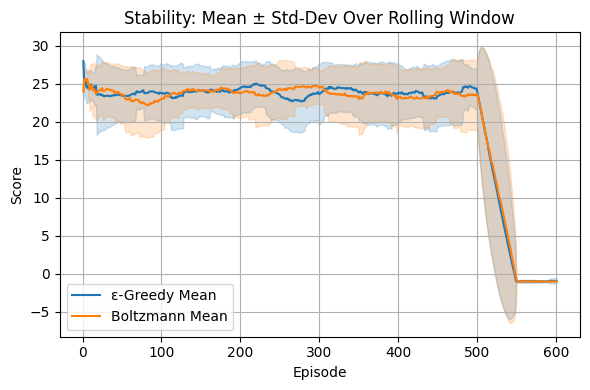


Time to reach running-avg ≥ 3.0:
  ε-Greedy:   1 episodes
  Boltzmann:  1 episodes



In [ ]:
"""### 3.3 Comparative Analysis"""

import matplotlib.pyplot as plt
import numpy as np

# ───────────────────────────────────────────────────────────────────────────────
#   3.3 Comparative Analysis (fixed)
# ───────────────────────────────────────────────────────────────────────────────

window = 50

# ─── 3.3.1 Compute running-average of episode scores (window = 50) ───────────

# ε-Greedy running average (one entry per episode in 'scores')
running_avg_eps = []
for i in range(len(scores)):
    if i < window:
        running_avg_eps.append(sum(scores[: i+1]) / (i+1))
    else:
        running_avg_eps.append(sum(scores[i-window+1 : i+1]) / window)

# Boltzmann running average (one entry per episode in 'scores_boltz')
running_avg_b = []
for i in range(len(scores_boltz)):
    if i < window:
        running_avg_b.append(sum(scores_boltz[: i+1]) / (i+1))
    else:
        running_avg_b.append(sum(scores_boltz[i-window+1 : i+1]) / window)

# Determine how many episodes each method actually ran
num_eps_eps    = len(running_avg_eps)       # e.g. 600 if fully run
num_eps_boltz  = len(running_avg_b)         # maybe < 600 if terminated early
common_eps     = min(num_eps_eps, num_eps_boltz)

# ─── 3.3.2 Plot Learning Curves (ε-Greedy vs. Boltzmann) ──────────────────────
episodes = np.arange(1, common_eps + 1)

plt.figure(figsize=(7,4))
plt.plot(
    episodes,
    running_avg_eps[:common_eps],
    label="ε-Greedy (window=50)",
    color="tab:blue",
    linewidth=1
)
plt.plot(
    episodes,
    running_avg_b[:common_eps],
    label="Boltzmann (window=50)",
    color="tab:orange",
    linewidth=1
)
plt.xlabel("Episode")
plt.ylabel(f"Avg Score (window={window})")
plt.title("Learning Curves: ε-Greedy vs. Boltzmann")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ─── 3.3.3 Final Performance Comparison (Last 200 Episodes Average) ──────────

n_last = 200

# If fewer than 200 episodes exist, average over all that are available
if len(scores) >= n_last:
    final_avg_eps = sum(scores[-n_last:]) / n_last
else:
    final_avg_eps = sum(scores) / len(scores)

if len(scores_boltz) >= n_last:
    final_avg_boltz = sum(scores_boltz[-n_last:]) / n_last
else:
    final_avg_boltz = sum(scores_boltz) / len(scores_boltz)

print(f"Final {n_last}-episode avg (ε-Greedy):   {final_avg_eps:.3f}")
print(f"Final {n_last}-episode avg (Boltzmann):   {final_avg_boltz:.3f}")


# ─── 3.3.4 Apples per Episode: running average ─────────────────────────────────

running_avg_apples_eps = []
running_avg_apples_b   = []

# Only iterate up to the shorter of the two apple‐counts lists
common_apples = min(len(apples), len(apples_boltz))

for i in range(common_apples):
    # ε-Greedy apples
    if i < window:
        running_avg_apples_eps.append(sum(apples[: i+1]) / (i+1))
    else:
        running_avg_apples_eps.append(sum(apples[i-window+1 : i+1]) / window)

    # Boltzmann apples
    if i < window:
        running_avg_apples_b.append(sum(apples_boltz[: i+1]) / (i+1))
    else:
        running_avg_apples_b.append(sum(apples_boltz[i-window+1 : i+1]) / window)

episodes_apples = np.arange(1, common_apples + 1)

plt.figure(figsize=(7,4))
plt.plot(
    episodes_apples,
    running_avg_apples_eps,
    label="Apples (ε-Greedy)",
    color="tab:blue",
    linewidth=1
)
plt.plot(
    episodes_apples,
    running_avg_apples_b,
    label="Apples (Boltzmann)",
    color="tab:orange",
    linewidth=1
)
plt.xlabel("Episode")
plt.ylabel(f"Avg Apples (window={window})")
plt.title("Average Apples Eaten: ε-Greedy vs. Boltzmann")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ─── 3.3.5 Exploration Schedules: Plot ε vs. T on a dual‐axis ──────────────────

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(
    eps_history,
    color="tab:blue",
    alpha=0.7,
    label="ε (ε-Greedy)"
)
ax1.set_xlabel("Time-step (t)")
ax1.set_ylabel("Epsilon (ε)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(
    temp_history,
    color="tab:orange",
    alpha=0.7,
    label="T (Boltzmann)"
)
ax2.set_ylabel("Temperature (T)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.suptitle("Exploration Schedules: ε (ε-Greedy) vs. T (Boltzmann)")
fig.tight_layout()
plt.show()


# ─── 3.3.6 Histogram of Action Distributions (optional) ────────────────────────

try:
    # Only compare up to the shorter history length
    min_len = min(len(action_hist_eps), len(action_hist_boltz))
    plt.figure(figsize=(6,4))
    plt.hist(
        action_hist_eps[:min_len],
        bins=[0,1,2,3],
        alpha=0.5,
        density=True,
        color="tab:blue",
        label="ε-Greedy"
    )
    plt.hist(
        action_hist_boltz[:min_len],
        bins=[0,1,2,3],
        alpha=0.5,
        density=True,
        color="tab:orange",
        label="Boltzmann"
    )
    plt.xticks([0,1,2], ["Left","Straight","Right"])
    plt.xlabel("Action index")
    plt.ylabel("Relative Frequency")
    plt.title("Action Distribution During Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception:
    pass


# ─── 3.3.7 Stability: Plot ±1 Std-Dev Shaded Region ───────────────────────────

# Compute mean/std over rolling window for ε-Greedy
means_eps = []
stds_eps  = []
for i in range(len(scores)):
    if i < window:
        segment = scores[: i+1]
    else:
        segment = scores[i-window+1 : i+1]
    means_eps.append(np.mean(segment))
    stds_eps.append(np.std(segment))

# Compute mean/std over rolling window for Boltzmann
means_b = []
stds_b  = []
for i in range(len(scores_boltz)):
    if i < window:
        segment = scores_boltz[: i+1]
    else:
        segment = scores_boltz[i-window+1 : i+1]
    means_b.append(np.mean(segment))
    stds_b.append(np.std(segment))

# Plot up to whichever series is shorter
common_stability = min(len(means_eps), len(means_b))
episodes_stab   = np.arange(1, common_stability + 1)

plt.figure(figsize=(6,4))
# ε-Greedy mean ± std
plt.plot(
    episodes_stab,
    means_eps[:common_stability],
    color="tab:blue",
    label="ε-Greedy Mean"
)
plt.fill_between(
    episodes_stab,
    np.array(means_eps[:common_stability]) - np.array(stds_eps[:common_stability]),
    np.array(means_eps[:common_stability]) + np.array(stds_eps[:common_stability]),
    color="tab:blue",
    alpha=0.2
)

# Boltzmann mean ± std
plt.plot(
    episodes_stab,
    means_b[:common_stability],
    color="tab:orange",
    label="Boltzmann Mean"
)
plt.fill_between(
    episodes_stab,
    np.array(means_b[:common_stability]) - np.array(stds_b[:common_stability]),
    np.array(means_b[:common_stability]) + np.array(stds_b[:common_stability]),
    color="tab:orange",
    alpha=0.2
)

plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Stability: Mean ± Std-Dev Over Rolling Window")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ─── 3.3.8 Hyperparameter Sensitivity (optional) ──────────────────────────────

target = 3.0
ep_eps_3 = next((i+1 for i, avg in enumerate(running_avg_eps) if avg >= target), None)
ep_b_3   = next((i+1 for i, avg in enumerate(running_avg_b)   if avg >= target), None)

print(f"\nTime to reach running-avg ≥ {target}:")
print(f"  ε-Greedy:   {ep_eps_3} episodes")
print(f"  Boltzmann:  {ep_b_3} episodes\n")